# Forward dynamics of infection on Zachary’s karate club data
Comparison with Fig. 2 in *Ortega et. al*, [Dynamics of epidemics from cavity master equations: Susceptible-infectious-susceptible models](https://doi.org/10.1103/PhysRevE.105.024308)

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots, Statistics, LaTeXStrings
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
import Measurements: value
using Random
using JLD2;

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [2]:
# read matrix of contacts, found at http://konect.cc/networks/ucidata-zachary/
A = readdlm("karate.txt", Bool)
g = IndexedGraph(A);

In [3]:
function make_sis(N, T, Δt, λ, ρ)
    sis = SIS(g, λ*Δt, ρ*Δt, floor(Int, T/Δt))
    for i in 1:N
       if i == 1
            sis.ϕ[i][1] .= [0.0, 1.0]   # node 1 is infected at time zero
        else
            sis.ϕ[i][1] .= [1.0, 0.0]   # all other nodes start as susceptible
        end
    end
    bp = mpbp(sis)
end

make_sis (generic function with 1 method)

In [4]:
function sample_light(bp::MPBP, nsamples; ntimes=getT(bp), i=30, info="MonteCarlo")
    local T = getT(bp)
    range = 1:((T+1)÷ntimes):(T+1)
    av = zeros(length(range))
    p⁰ = [ϕᵢ[1] ./ sum(ϕᵢ[1]) for ϕᵢ in bp.ϕ]
    x = zeros(Int, nv(bp.g), T+1)
    ProgressMeter.@showprogress info for n in 1:nsamples
        onesample!(x, bp; p⁰)
        av .+= @views x[i,range]
    end
    av ./= nsamples
    av .-= 1
    av
end      

sample_light (generic function with 1 method)

In [32]:
N = nv(g)  # number of individuals
T = 50     # final time
λ = 0.1    # prob. of transmission
ρ = 0.05   # prob. of recovery
;

In [6]:
Δts = [1.0, 0.1, 0.01]
avs = Vector{Float64}[]
for a in eachindex(Δts)
    Δt = Δts[a]
    bp = make_sis(N, T, Δt, λ, ρ)
    av = sample_light(bp, 10^4; ntimes=min(getT(bp), 100), info="Run $a of $(length(Δts))")
    push!(avs, av)
end

Run 1 of 3 100%|█████████████████████████████████████████| Time: 0:00:04
Run 2 of 3 100%|█████████████████████████████████████████| Time: 0:00:43
Run 3 of 3 100%|█████████████████████████████████████████| Time: 0:15:32


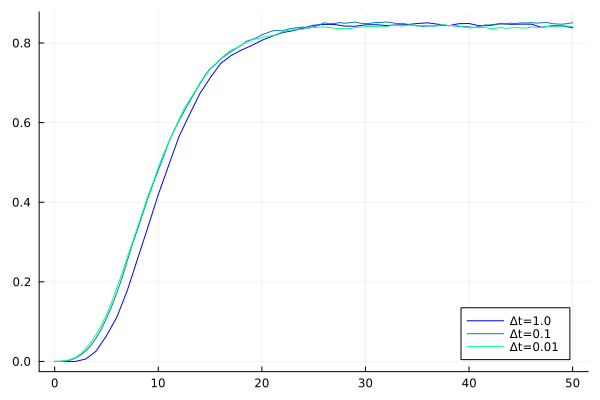

In [23]:
using ColorSchemes
cg = cgrad(:winter, length(Δts), categorical=true)
pl = plot(legend=:bottomright)
for a in eachindex(Δts)
    Δt = Δts[a]
    av = avs[a]
    plot!(pl, (eachindex(av).-1).*max(0.5,Δt), av, c=cg[a], label="Δt=$(Δt)")
end
plot(pl)

### Continuous MC

In [8]:
using CavityTools

# Λ = contact network
# λ = rate of infection
# μ[i] = rate of recovery of I
# T = final time 
∂(g, i) = neighbors(g, i)

function simulate_queue_sis!(x, g, P0, λ, μ, T;
    stats=(t, i, x) -> println("$t $i $(x[i])"),
    Q=ExponentialQueue(N))

    N = length(P0)
    t = 0.0
    x .= false
    empty!(Q)
    for i = 1:N
        if rand() < P0[i]
            Q[i] = Inf
        end
    end
    while !isempty(Q)
        i, Δt = pop!(Q)
        t += Δt
        t > T && break
        x[i] = !x[i]
        stats(t, i, x)
        if x[i] == 1
            Q[i] = μ[i]
            for j in ∂(g, i)
                if x[j] == 0
                    Q[j] = j ∈ Q ? Q[j] + λ : λ
                end
            end
        elseif x[i] == 0
            s = 0.0
            for j in ∂(g, i)
                if x[j] == 0
                    if j ∈ Q
                        Q[j] -= λ
                    end
                else
                    s += λ
                end
            end
            Q[i] = s
        end
    end
    x
end


simulate_queue_sis! (generic function with 1 method)

In [13]:
N = nv(g)
μ = fill(ρ,N)
λ = λ
P0 = [i==1 ? 1.0 : 0.0 for i in 1:N];

In [15]:
function TrajectoryRecorder()
    v = Tuple{Float64,Int,Int}[]
    function stats(t, i, x)
        push!(v, (t,i,x[i]))
    end
end

q = TrajectoryRecorder();
x = fill(false, N);
Q = ExponentialQueue(N)
s = zeros(N)
nsamples = 10^4
Δt_cont = 0.1
K = floor(Int, T/Δt_cont) + 1
ni = zeros(Int, K)
av_cont = zeros(K)
va = zeros(K)
for i=1:nsamples
    ni .= 0
    empty!(q.v)
    simulate_queue_sis!(x, g, P0, λ, μ, T; stats = q, Q=Q)
#     if sum(x)>0
        for (t,j,x) in q.v
            if j == 30
                k = floor(Int, t/Δt_cont) + 1
                @assert t <= T
                @assert k <= K
                ni[k] += 2x-1
            end
        end
#     end
    for k=2:length(ni)
        ni[k] += ni[k-1]
    end
    av_cont .+= ni
    va .+= ni .^ 2

end
av_cont ./= nsamples
va ./= nsamples
va .-= av_cont .^ 2
[av_cont sqrt.(va)];

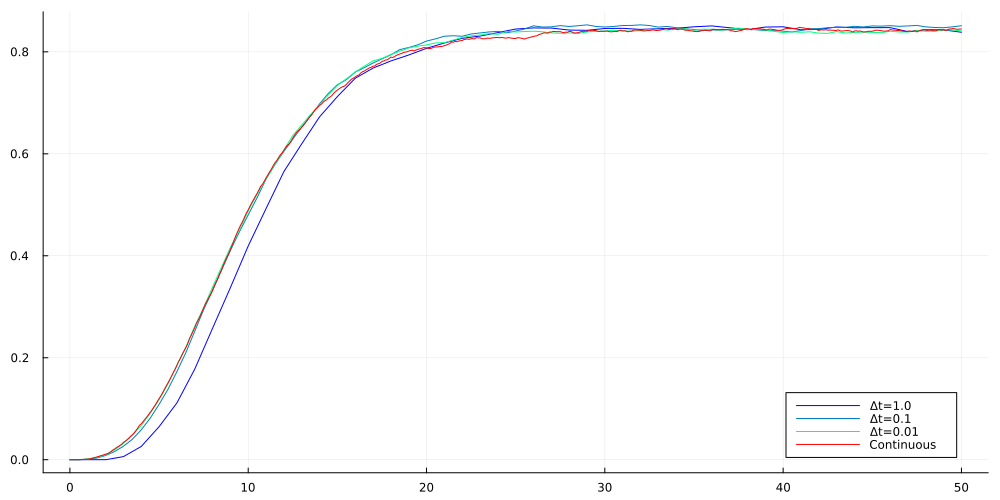

In [30]:
plot!(deepcopy(pl), (eachindex(av_cont).-1).*Δt_cont, av_cont, label="Continuous",
    c=:red, size=(1000,500))

In [31]:
savefig(ans, "karate_discretizations.pdf")

"/home/crotti/MatrixProductBP/notebooks/karate_discretizations.pdf"

In [ ]:
Δt = 0.02 #ΔT
Tdisc = floor(Int, T/Δt)

ϕ = [zeros(ne(bp.g)) for t in 0:Tdisc]
r = [zeros(nv(bp.g)) for t in 0:Tdisc]

r[1][1] = 1

for (i,j,id) in edges(g)
    ϕ[1][id] = r[1][i]*(1-r[1][j])
end

In [ ]:
r_cme = deepcopy(r)
ϕ_cme = deepcopy(ϕ)
cme!(r_cme, ϕ_cme, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_cme = [[rt[i] for rt in r_cme] for i in 1:N];

In [ ]:
r_dmp = deepcopy(r)
ϕ_dmp = deepcopy(ϕ)
dmp!(r_dmp, ϕ_dmp, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_dmp = [[rt[i] for rt in r_dmp] for i in 1:N];

In [ ]:
r_ibmf = deepcopy(r)
ibmf!(r_ibmf, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_ibmf = [[rt[i] for rt in r_ibmf] for i in 1:N];

In [155]:
Δt = 0.02

0.02

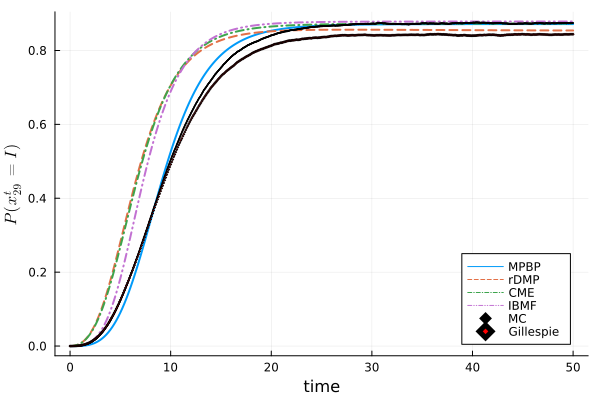

In [156]:
Plots.default(lw=2)

pl = plot(xlabel="time", xticks=0:10:T, ylabel="\$P(x_{29}^t=I)\$", legend=:bottomright)
plot!(pl, 0:ΔT:T, p29_bp, label="MPBP")
plot!(pl, 0:Δt:T, p_dmp[30], ls=:dash, label="rDMP")
plot!(pl, 0:Δt:T, p_cme[30], ls=:dashdot, label="CME")
plot!(pl, 0:Δt:T, p_ibmf[30], ls=:dashdotdot, label="IBMF")
# plot!(pl, 0:Δt:T, p_pbmf1[30], ls=:dashdotdot, label="PBMF1")
scatter!(pl, 0:Δt:T, value.(p29_mc), m=:diamond, ms=1, label="MC", c=:black)
plot!(pl, 0:0.1:T, av, label="Gillespie", m=:diamond, c=:red, st=:scatter, ms=1)

# ylims = (0.85,0.88)
# plot!(pl, xticks=T-5:1:T, ylims=ylims, xlims=(T-5,T),
#     inset=(1, bbox(0.5, 0.25, 0.45, 0.3)), subplot=2)
# plot!(pl[2], 0:ΔT:T, p29_bp, label="")
# plot!(pl[2], 0:Δt:T, p_dmp[30], ls=:dash, label="")
# plot!(pl[2], 0:Δt:T, p_cme[30], ls=:dashdot, label="")
# plot!(pl[2], 0:Δt:T, p_ibmf[30], ls=:dashdotdot, label="")
# scatter!(pl[2], 0:Δt:T, value.(p29_mc), m=:diamond, ms=3, label="", c=:black);

In [124]:
jldsave("plot_data/sis_karate_club_network.jld2"; T, ΔT, Δt, p_bp, p_mc, p_dmp, p_cme, p_ibmf, c_bp,
    λ, ρ, svd_trunc);

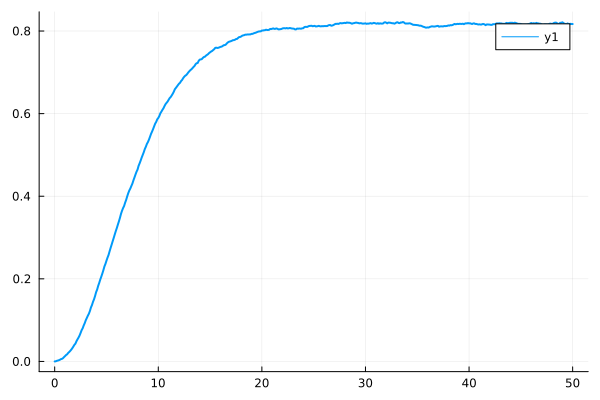

In [132]:
plot(0:Δt:T, av)